# Data Visualization and Analysis

This project is divided into two major parts. In the first part, you will conduct an exploratory data analysis on a dataset of your choosing. You will use Python data science and data visualization libraries to explore the dataset’s variables and understand the data’s structure, oddities, patterns and relationships.

In the second part, you will take your main findings from your exploration and convey them to others through an explanatory analysis. To this end, you will create a slide deck that leverages polished, explanatory visualizations to communicate your results. 

Data source: [Ford GoBike System Data](https://www.lyft.com/bikes/bay-wheels/system-data) captured during 2019 Aug.

The proejct aims to answer below questions: 
- Who are the customers?
- When are most trips taken in terms of time of day or day of the week?
- How long does the average trip take?
- Does the above depend on if a user is a subscriber or customer?

## Preliminary Wrangling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

%matplotlib inline

df=pd.read_csv('201908-baywheels-tripdata.csv')
df.head(2)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,68145,2019-08-31 21:27:42.2530,2019-09-01 16:23:27.4920,249,Russell St at College Ave,37.858473,-122.253253,247,Fulton St at Bancroft Way,37.867789,-122.265896,3112,Customer,NaN,NaN,No
1,53216,2019-08-31 22:34:17.5120,2019-09-01 13:21:13.9310,368,Myrtle St at Polk St,37.785434,-122.419622,78,Folsom St at 9th St,37.773717,-122.411647,2440,Customer,1993.0,Female,No


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210563 entries, 0 to 210562
Data columns (total 16 columns):
duration_sec               210563 non-null int64
start_time                 210563 non-null object
end_time                   210563 non-null object
start_station_id           210563 non-null int64
start_station_name         210563 non-null object
start_station_latitude     210563 non-null float64
start_station_longitude    210563 non-null float64
end_station_id             210563 non-null int64
end_station_name           210563 non-null object
end_station_latitude       210563 non-null float64
end_station_longitude      210563 non-null float64
bike_id                    210563 non-null int64
user_type                  210563 non-null object
member_birth_year          170774 non-null float64
member_gender              170777 non-null object
bike_share_for_all_trip    210563 non-null object
dtypes: float64(5), int64(4), object(7)
memory usage: 25.7+ MB


In [3]:
df[['member_birth_year','member_gender']].isna().sum()

member_birth_year    39789
member_gender        39786
dtype: int64

In [4]:
# set dates to timestamps
df.start_time = pd.to_datetime(df.start_time)
df.end_time = pd.to_datetime(df.end_time)

# clean categorical data
df.user_type = df.user_type.astype('category')
df.member_gender = df.member_gender.astype('category')
df.bike_share_for_all_trip = df.bike_share_for_all_trip.astype('category')

df.bike_id = df.bike_id.astype(str)
df.start_station_id = df.bike_id.astype(str)
df.end_station_id = df.bike_id.astype(str)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210563 entries, 0 to 210562
Data columns (total 16 columns):
duration_sec               210563 non-null int64
start_time                 210563 non-null datetime64[ns]
end_time                   210563 non-null datetime64[ns]
start_station_id           210563 non-null object
start_station_name         210563 non-null object
start_station_latitude     210563 non-null float64
start_station_longitude    210563 non-null float64
end_station_id             210563 non-null object
end_station_name           210563 non-null object
end_station_latitude       210563 non-null float64
end_station_longitude      210563 non-null float64
bike_id                    210563 non-null object
user_type                  210563 non-null category
member_birth_year          170774 non-null float64
member_gender              170777 non-null category
bike_share_for_all_trip    210563 non-null category
dtypes: category(3), datetime64[ns](2), float64(5), int64(1), o

## User Profiling

Explore user characteristics, including
- Age 
- Gender 
- User type

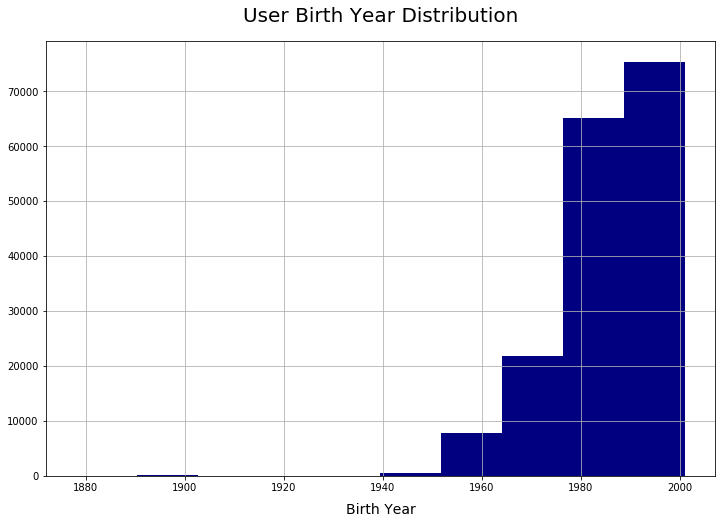

In [6]:
df['member_birth_year'].hist(figsize=(12,8),color ='navy')
plt.title("User Birth Year Distribution", fontsize=20, y=1.03)
plt.xlabel("Birth Year", fontsize=14, labelpad=10);

Observations:
> Majority of users are born between 1975 to 1998, age around 44 years old to 21 years old

> For easier interpretation, will convert birth year to age in next plot

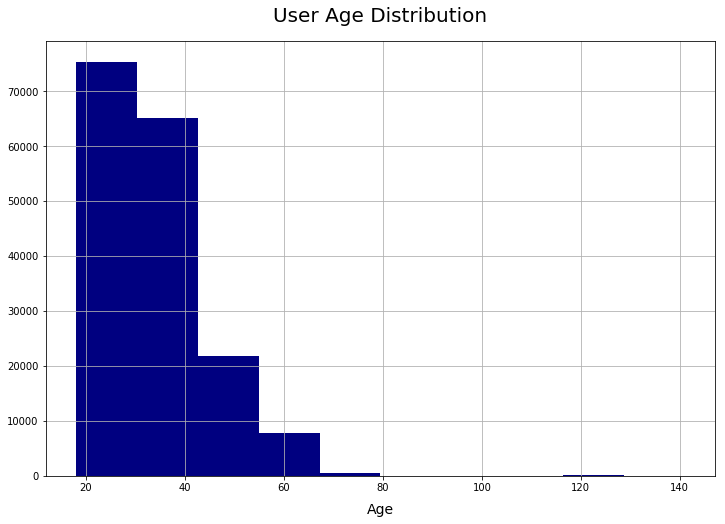

In [7]:
# derive member age for segmentation profiling
df['member_age'] = 2019-df['member_birth_year']
df['member_age'].hist(figsize=(12,8),color='navy')
plt.title("User Age Distribution", fontsize=20, y=1.03)
plt.xlabel("Age", fontsize=14, labelpad=10);

## Observations:
> Majority users are between 18 to 40 years old, who might be more willing to ride bike for travel.

> Users aged above 80 might be caused by abnormal data, which will be cleaned in next step.

In [8]:
df['member_age'].describe(percentiles = [ .95])

count    170774.000000
mean         34.035550
std          10.037432
min          18.000000
50%          32.000000
95%          54.000000
max         141.000000
Name: member_age, dtype: float64

In [9]:
df.query('member_age == "NaN" ').bike_id.count(),df.query('member_age >60 ').bike_id.count()

(39789, 3280)

Clean member age data
> As shown above, there are some customers with null birth year or with age above 60 years. As 95% of the users are below 54, I am going to keep users below 60.

In [10]:
# Clean member age, and drop those order than 60
df=df.query('member_age == "NaN" or member_age < 60')
df.head(2)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,member_age
0,68145,2019-08-31 21:27:42.253,2019-09-01 16:23:27.492,3112,Russell St at College Ave,37.858473,-122.253253,3112,Fulton St at Bancroft Way,37.867789,-122.265896,3112,Customer,NaN,NaN,No,NaN
1,53216,2019-08-31 22:34:17.512,2019-09-01 13:21:13.931,2440,Myrtle St at Polk St,37.785434,-122.419622,2440,Folsom St at 9th St,37.773717,-122.411647,2440,Customer,1993.0,Female,No,26.0


In [11]:
#Generate a new field for member age group from member_age_bin
df['member_age_bins'] = df['member_age'].apply(lambda x: '10 - 20' if 10<x<=20
                                                  else '20 - 30' if 20<x<=30
                                                  else '30 - 40' if 30<x<=40
                                                  else '40 - 50' if 40<x<=50
                                                  else '50 - 60' if 50<x<=60
                                                  else '60 - 70' if 60<x<=70
                                                  else '70 - 80' if 70<x<=80
                                                  else x)

df.head(2)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,member_age,member_age_bins
0,68145,2019-08-31 21:27:42.253,2019-09-01 16:23:27.492,3112,Russell St at College Ave,37.858473,-122.253253,3112,Fulton St at Bancroft Way,37.867789,-122.265896,3112,Customer,NaN,NaN,No,NaN,NaN
1,53216,2019-08-31 22:34:17.512,2019-09-01 13:21:13.931,2440,Myrtle St at Polk St,37.785434,-122.419622,2440,Folsom St at 9th St,37.773717,-122.411647,2440,Customer,1993.0,Female,No,26.0,20 - 30


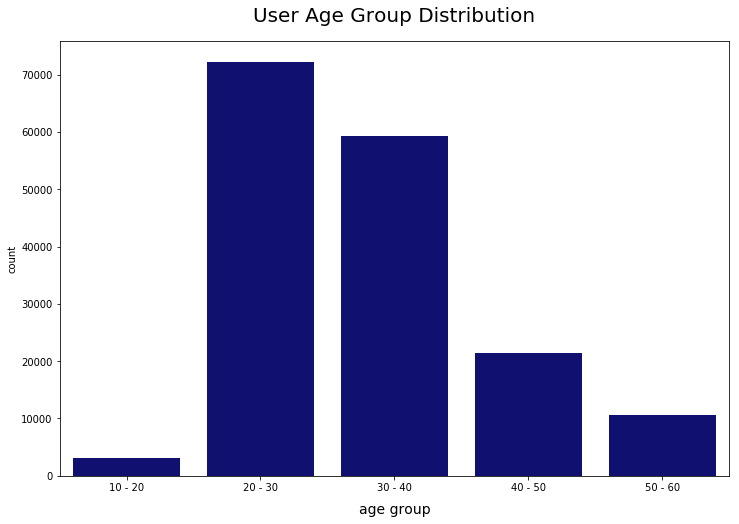

In [12]:
plt.figure(figsize = [12, 8])
sns.countplot(x='member_age_bins', data=df.sort_values(by='member_age_bins'),color='navy')
plt.title("User Age Group Distribution", fontsize=20, y=1.03)
plt.xlabel("age group", fontsize=14, labelpad=10)
plt.xticks(rotation=360);

Observations:
> Majority users are between 20 to 40 years old.

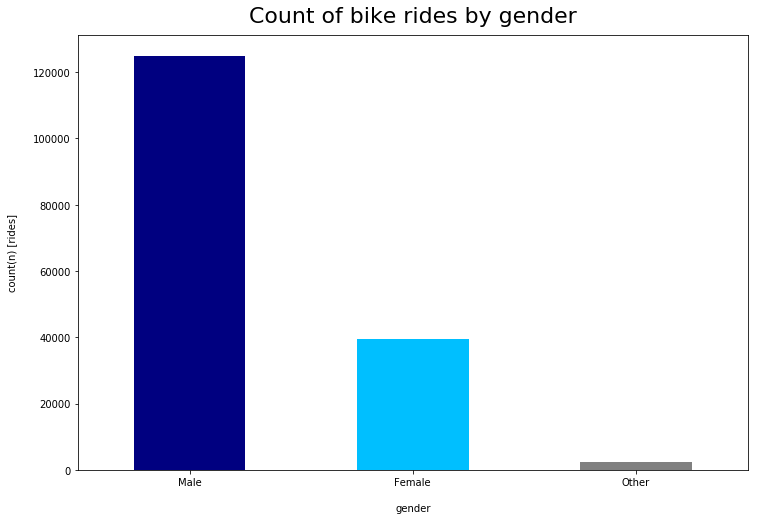

In [13]:
df['member_gender'].value_counts().plot.bar(color=['navy','deepskyblue','gray'],figsize=(12,8), legend=False)
plt.title('Count of bike rides by gender', fontsize=22, y=1.015)
plt.xlabel('gender', labelpad=16)
plt.ylabel('count(n) [rides]', labelpad=16)
plt.xticks(rotation=360);

Observations:
> Counts of rides by male users tripled that of female users.

> The user from Others group might be caused by abnormal data, or company failed to capture user gender.

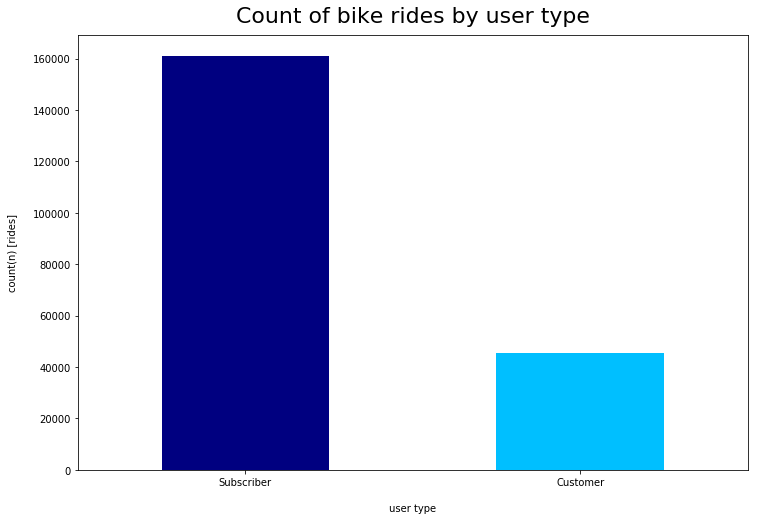

In [14]:
df['user_type'].value_counts().plot.bar(color=['navy','deepskyblue'],figsize=(12,8), legend=False)
plt.title('Count of bike rides by user type', fontsize=22, y=1.015)
plt.xlabel('user type', labelpad=16)
plt.ylabel('count(n) [rides]', labelpad=16)
plt.xticks(rotation=360);

## Ride Statistics

Explore ride statistics, including

- Percentage of Bike Rides by Weekday 
- Count of Rides by Each Day in Aug
- Count of Rides by Start Hour of Day

In [15]:
# extract start time month name
df['start_time_month_name']=df['start_time'].dt.strftime('%B')

# extract start time month number
df['start_time_month']=df['start_time'].dt.month.astype(int)

# extract start time weekdays
df['start_time_weekday']=df['start_time'].dt.strftime('%a')

# extract start time day
df['start_time_day']=df['start_time'].dt.day.astype(int)

# extract start time hour
df['start_time_hour']=df['start_time'].dt.hour
df.head(2)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,member_birth_year,member_gender,bike_share_for_all_trip,member_age,member_age_bins,start_time_month_name,start_time_month,start_time_weekday,start_time_day,start_time_hour
0,68145,2019-08-31 21:27:42.253,2019-09-01 16:23:27.492,3112,Russell St at College Ave,37.858473,-122.253253,3112,Fulton St at Bancroft Way,37.867789,...,NaN,NaN,No,NaN,NaN,August,8,Sat,31,21
1,53216,2019-08-31 22:34:17.512,2019-09-01 13:21:13.931,2440,Myrtle St at Polk St,37.785434,-122.419622,2440,Folsom St at 9th St,37.773717,...,1993.0,Female,No,26.0,20 - 30,August,8,Sat,31,22


In [16]:
sns.set_style('whitegrid')
sns.set_context("talk")

In [17]:
df['start_time_weekday'].value_counts()

Thu    38738
Fri    35758
Wed    32265
Tue    31863
Mon    30749
Sat    20992
Sun    16302
Name: start_time_weekday, dtype: int64

In [18]:
weekday_index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

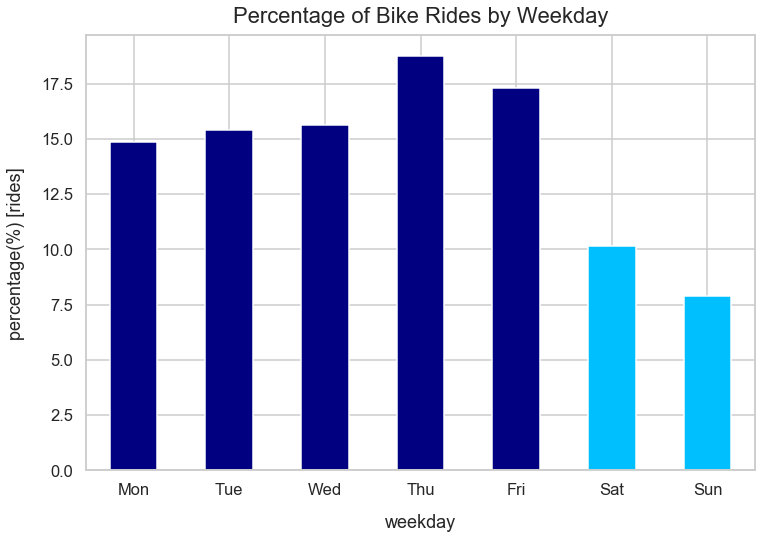

In [19]:
#plot counts by start weekday
df_weekday = df.groupby(["start_time_weekday"]).aggregate({'bike_id':'count'})
new_color = ['navy', 'navy', 'navy', 'navy', 'navy', 'deepskyblue', 'deepskyblue']
df_weekday['perc'] = (df_weekday['bike_id']/df_weekday['bike_id'].sum())*100


df_weekday.reindex(weekday_index)['perc'].plot(kind='bar', color=new_color, figsize=(12,8), legend=False)
plt.title('Percentage of Bike Rides by Weekday', fontsize=22, y=1.015)
plt.xlabel('weekday', labelpad=16)
plt.ylabel('percentage(%) [rides]', labelpad=16)
plt.xticks(rotation=360);

Observations:
> Users ride bikes far more often on weekdays than on weekends.

> The pattern might be due to different use scenarios. Users ride bikes to commute between workplace and home on weekdays.

In [20]:
df['start_time_month_name'].value_counts()

August    206667
Name: start_time_month_name, dtype: int64

In [21]:
df['start_time_month'].value_counts()

8    206667
Name: start_time_month, dtype: int64

In [22]:
df['start_time_day'].value_counts()

21    8308
14    8230
27    8230
28    8188
20    8166
22    8163
26    8108
29    7974
15    7875
13    7817
6     7650
19    7638
12    7590
23    7575
7     7539
8     7471
5     7413
16    7413
1     7255
9     7123
30    6839
2     6808
17    4530
24    4276
11    4251
25    4237
10    4221
3     4160
18    3983
4     3831
31    3805
Name: start_time_day, dtype: int64

In [23]:
df['weekday_or_weekend']=df['start_time_weekday'].apply(lambda x: "weekend" if (x =='Sat' or x =='Sun') else "weekday")
df.tail(2)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,member_gender,bike_share_for_all_trip,member_age,member_age_bins,start_time_month_name,start_time_month,start_time_weekday,start_time_day,start_time_hour,weekday_or_weekend
210561,111,2019-08-01 00:11:02.582,2019-08-01 00:12:54.134,1910,Telegraph Ave at 19th St,37.808702,-122.269927,1910,Telegraph Ave at 23rd St,37.812678,...,Male,No,26.0,20 - 30,August,8,Thu,1,0,weekday
210562,255,2019-08-01 00:04:27.953,2019-08-01 00:08:43.337,3703,4th St at 16th St,37.767045,-122.390833,3703,4th St at 16th St,37.767045,...,Male,No,29.0,20 - 30,August,8,Thu,1,0,weekday


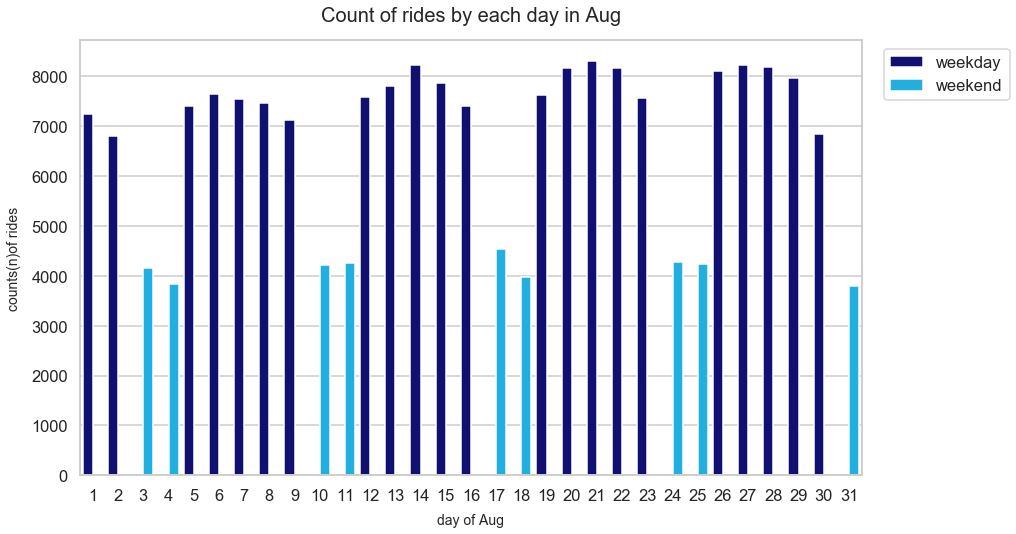

In [24]:
#plot counts by start time on weekday and weekend
my_palette = {'weekday': 'navy', 'weekend': 'deepskyblue'}

plt.figure(figsize = [14, 8])
ax=sns.countplot(x='start_time_day',hue='weekday_or_weekend',palette=my_palette,data=df.sort_values(by=['start_time_day','weekday_or_weekend']))
plt.title("Count of rides by each day in Aug", fontsize=20, y=1.03)
plt.xlabel("day of Aug", fontsize=14, labelpad=10)
plt.ylabel("counts(n)of rides", fontsize=14, labelpad=10)
plt.xticks(rotation=360)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1));

Observations:
> The pattern that users ride more on weekdays is consistently observed.

In [25]:
df_grp_by_start_hour=df.loc[:,('bike_id','start_time_hour','weekday_or_weekend')].groupby(['start_time_hour','weekday_or_weekend']).agg({'bike_id':'count'}).reset_index()
df_grp_by_start_hour.head(2)                                                                                      

,start_time_hour,weekday_or_weekend,bike_id
0,0,weekday,614
1,0,weekend,548


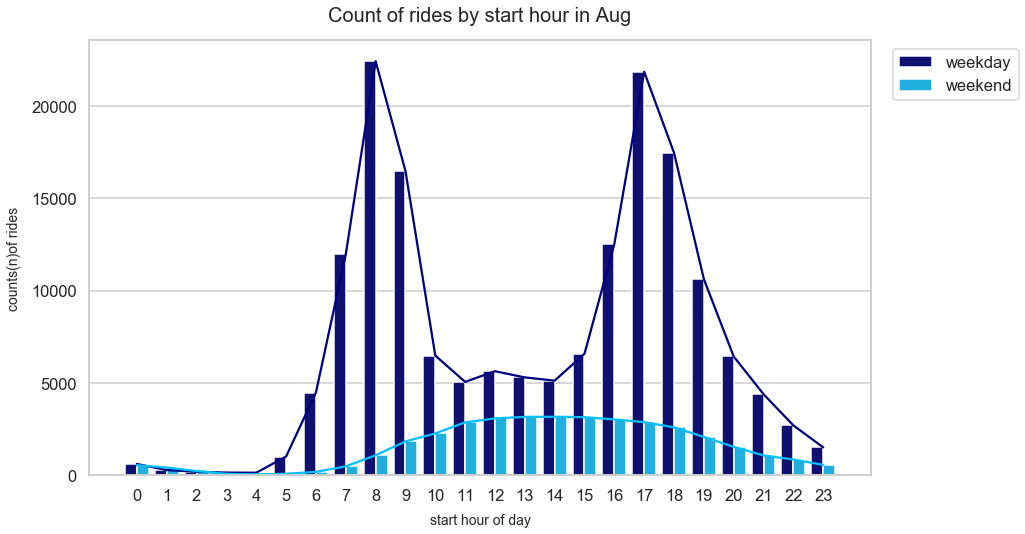

In [26]:
#plot counts by start_time_hour on weekday and weekend
my_palette = {'weekday': 'navy', 'weekend': 'deepskyblue'}

plt.figure(figsize = [14, 8])
ax=sns.countplot(x='start_time_hour',hue='weekday_or_weekend',palette=my_palette,data=df.sort_values(by=['start_time_hour','weekday_or_weekend']))
sns.lineplot(x='start_time_hour',y='bike_id',hue='weekday_or_weekend',data=df_grp_by_start_hour,palette=my_palette,legend=False)
plt.title("Count of rides by start hour in Aug", fontsize=20, y=1.03)
plt.xlabel("start hour of day", fontsize=14, labelpad=10)
plt.ylabel("counts(n)of rides", fontsize=14, labelpad=10)
plt.xticks(rotation=360)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1));


Observations:
> Peak hour pattern on weekdays is obvious, 7am-9am in the morning, and 4pm-7pm in the afternoon

> Peak hours is not observed on weekends.

> Users might ride bike on weekends for leisure purpose, hence, there is no clear peak hours.

In [27]:
#Generate new fields for estimated distance
import math
def distance(origin, destination):
    """
    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_km : float
    """
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

In [28]:
# Create estimate distance in km
df['distance_km_estimates'] = df.apply(lambda x: distance((x['start_station_latitude'], x['start_station_longitude']), (x['end_station_latitude'], x['end_station_longitude'])), axis=1)
df.head(2)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,bike_share_for_all_trip,member_age,member_age_bins,start_time_month_name,start_time_month,start_time_weekday,start_time_day,start_time_hour,weekday_or_weekend,distance_km_estimates
0,68145,2019-08-31 21:27:42.253,2019-09-01 16:23:27.492,3112,Russell St at College Ave,37.858473,-122.253253,3112,Fulton St at Bancroft Way,37.867789,...,No,NaN,NaN,August,8,Sat,31,21,weekend,1.518223
1,53216,2019-08-31 22:34:17.512,2019-09-01 13:21:13.931,2440,Myrtle St at Polk St,37.785434,-122.419622,2440,Folsom St at 9th St,37.773717,...,No,26.0,20 - 30,August,8,Sat,31,22,weekend,1.479392


## Ride Statistics by Use Type

- Average Duration of Rides by User Type
- Peak start hour by User Type
- Average Trip Distance by User Type

In [29]:
df_duration_time_weekday=df.loc[:,('duration_sec','user_type','member_gender')].groupby(['user_type','member_gender']).agg({'duration_sec':'mean'}).reset_index()
df_duration_time_weekday.head(10)

,user_type,member_gender,duration_sec
0,Customer,Female,1597.012950
1,Customer,Male,1206.313901
2,Customer,Other,1450.407821
3,Subscriber,Female,764.098918
4,Subscriber,Male,646.873700
5,Subscriber,Other,682.601968


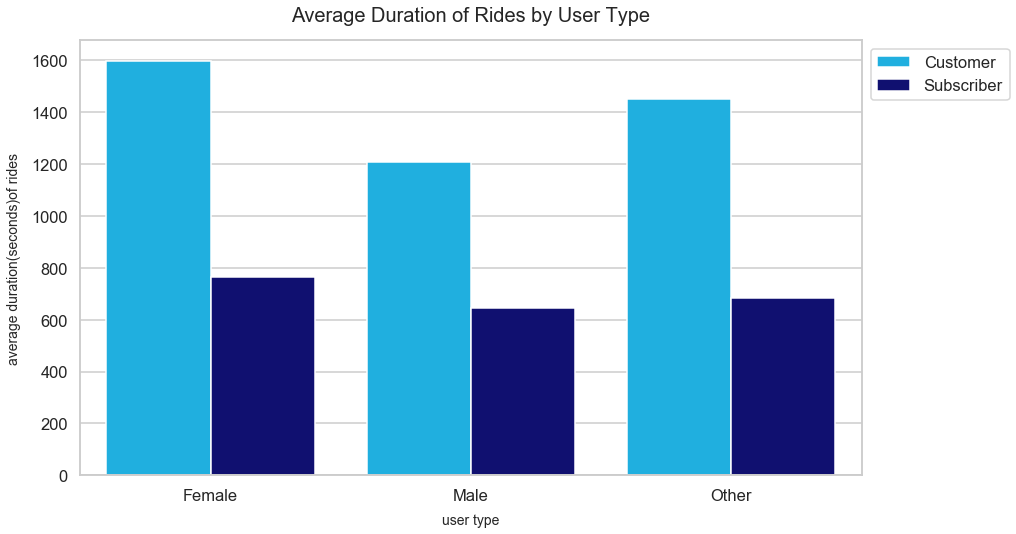

In [30]:
my_palette = {'Subscriber': 'navy', 'Customer': 'deepskyblue'}

plt.figure(figsize = [14, 8])
ax=sns.barplot(x='member_gender',y='duration_sec',hue='user_type',palette=my_palette,data=df_duration_time_weekday.sort_values(by=['user_type','member_gender']))
#sns.lineplot(x='start_time_hour',y='bike_id',hue='weekday_or_weekend',data=df_grp_by_start_hour,palette=my_palette,legend=False)
plt.title("Average Duration of Rides by User Type", fontsize=20, y=1.03)
plt.xlabel("user type", fontsize=14, labelpad=10)
plt.ylabel("average duration(seconds)of rides", fontsize=14, labelpad=10)
plt.xticks(rotation=360)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1));

Observations:
> Users from customer group ride longer time duration than that of subscriber group.

> Female users ride longer time duration than male users 

In [31]:
df_dist_user=df.loc[:,('distance_km_estimates','user_type','member_gender')].groupby(['user_type','member_gender']).agg({'distance_km_estimates':'mean'}).reset_index()
df_dist_user.head(10)

,user_type,member_gender,distance_km_estimates
0,Customer,Female,1.843015
1,Customer,Male,1.836422
2,Customer,Other,1.862277
3,Subscriber,Female,1.763144
4,Subscriber,Male,1.615188
5,Subscriber,Other,1.718052


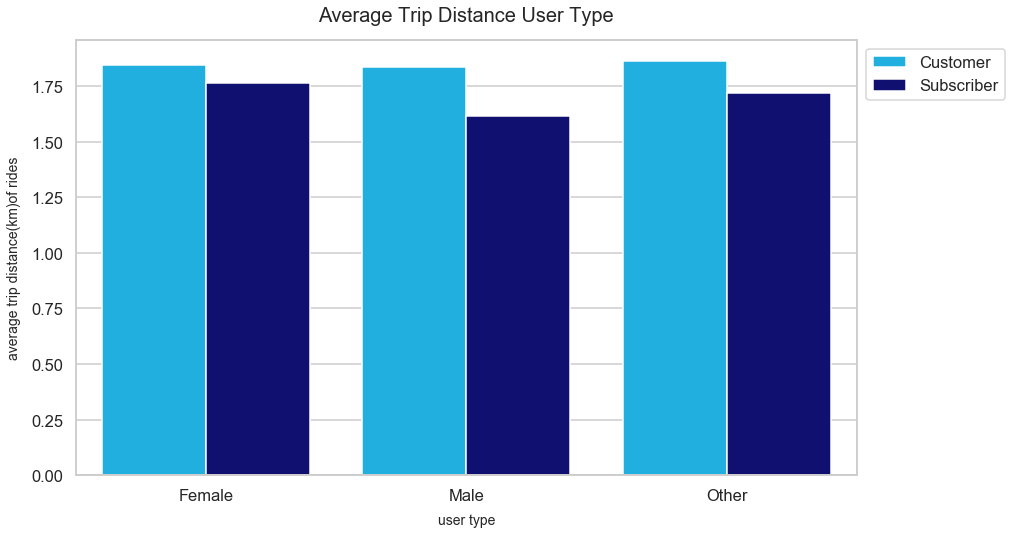

In [32]:
my_palette = {'Subscriber': 'navy', 'Customer': 'deepskyblue'}

plt.figure(figsize = [14, 8])
ax=sns.barplot(x='member_gender',y='distance_km_estimates',hue='user_type',palette=my_palette,data=df_dist_user.sort_values(by=['user_type','member_gender']))
#sns.lineplot(x='start_time_hour',y='bike_id',hue='weekday_or_weekend',data=df_grp_by_start_hour,palette=my_palette,legend=False)
plt.title("Average Trip Distance User Type", fontsize=20, y=1.03)
plt.xlabel("user type", fontsize=14, labelpad=10)
plt.ylabel("average trip distance(km)of rides", fontsize=14, labelpad=10)
plt.xticks(rotation=360)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

Observations:
> Although female users ride longer time duration than male users, the difference of average ride distance is insignifiant.

> Customer group ride longer distance than subscriber group

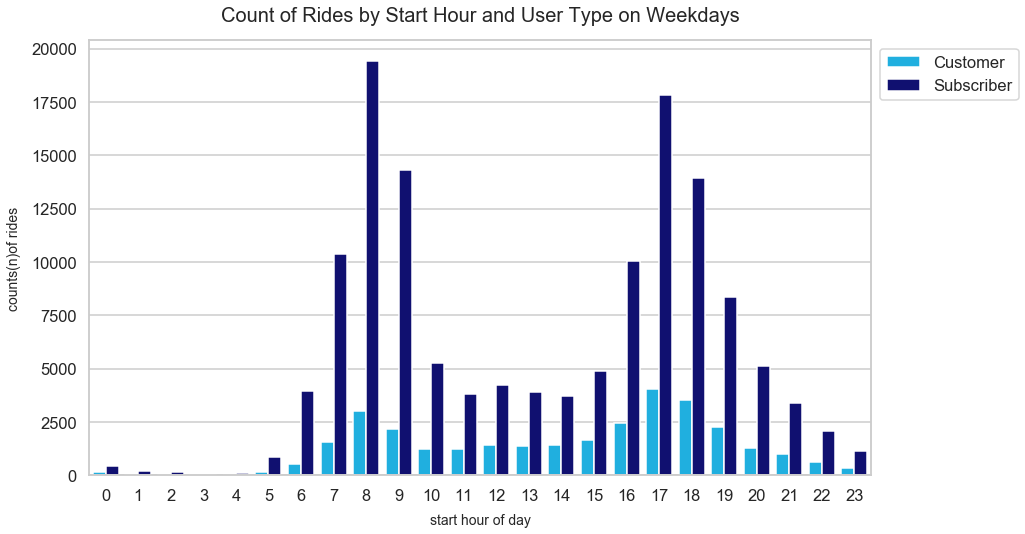

In [33]:
#plot counts by start_time_hour and user type on weekdays
my_palette = {'Subscriber': 'navy', 'Customer': 'deepskyblue'}
plt.figure(figsize = [14, 8])
ax=sns.countplot(x='start_time_hour',hue='user_type',palette=my_palette,data=df.query('weekday_or_weekend == "weekday"').sort_values(by=['start_time_hour','user_type']))
plt.title("Count of Rides by Start Hour and User Type on Weekdays", fontsize=20, y=1.03)
plt.xlabel("start hour of day", fontsize=14, labelpad=10)
plt.ylabel("counts(n)of rides", fontsize=14, labelpad=10)
plt.xticks(rotation=360)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))


Observations:
> Though subscriber group ride much more often than customer group, both group exhibit same travel peak hours on weekdays

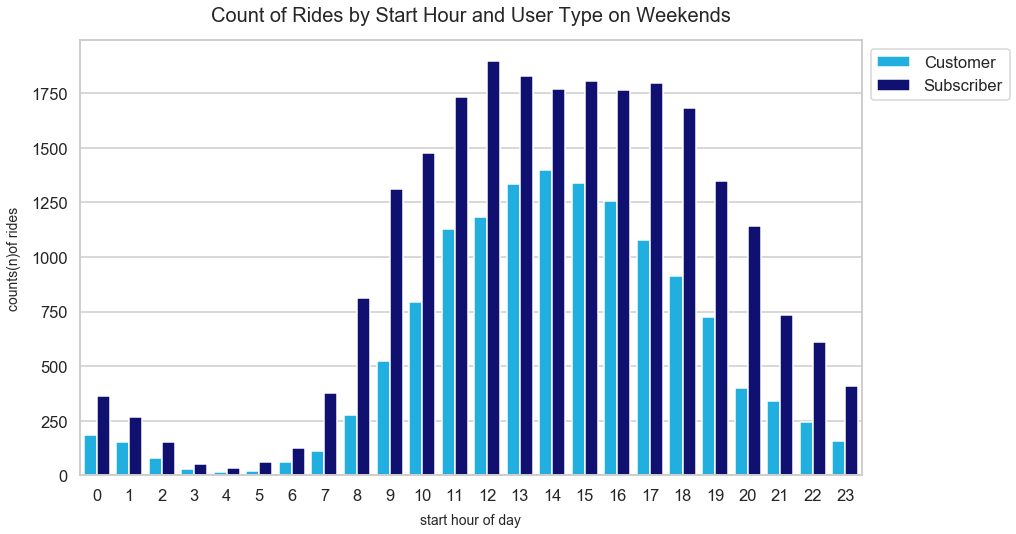

In [34]:
my_palette2 = {'Subscriber': 'navy', 'Customer': 'deepskyblue'}
plt.figure(figsize = [14, 8])
#ax=sns.countplot(x='start_time_hour',hue='user_type',palette=my_palette,data=df.query('weekday_or_weekend == "weekday"').sort_values(by=['start_time_hour','user_type']))
ax=sns.countplot(x='start_time_hour',hue='user_type',palette=my_palette2,data=df.query('weekday_or_weekend == "weekend"').sort_values(by=['start_time_hour','user_type']))
plt.title("Count of Rides by Start Hour and User Type on Weekends", fontsize=20, y=1.03)
plt.xlabel("start hour of day", fontsize=14, labelpad=10)
plt.ylabel("counts(n)of rides", fontsize=14, labelpad=10)
plt.xticks(rotation=360)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))


Observations:
> Though subscriber group ride slightly more often than customer group, both group exhibit same travel peak hours on weekends

> The difference of counts of rides on weekends between subscriber group and customer group is smaller than that of weekdays.

## Hourly Usage Differences on Weekdays between Customer Group and Subscriber Group

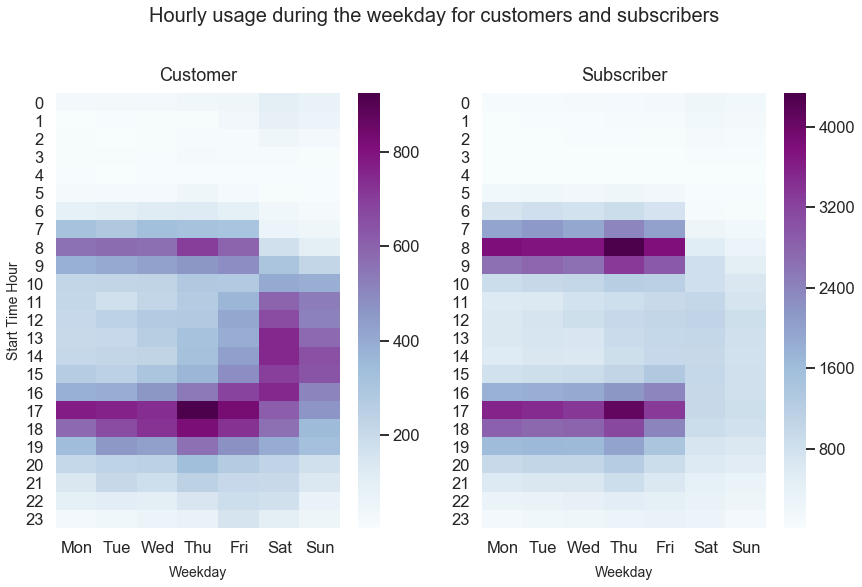

In [35]:
# Setting the weekday order
df['start_time_weekday'] = pd.Categorical(df['start_time_weekday'], 
                                                categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], 
                                                ordered=True)
plt.figure(figsize=(14,8))
plt.suptitle('Hourly usage during the weekday for customers and subscribers', fontsize=20, y=1.03)

# heatmap for customers
plt.subplot(1, 2, 1)

df_customer = df.query('user_type == "Customer"').groupby(["start_time_hour", "start_time_weekday"])["bike_id"].size().reset_index()
df_customer = df_customer.pivot("start_time_hour", "start_time_weekday", "bike_id")
sns.heatmap(df_customer, cmap="BuPu",fmt='d')

plt.title("Customer", y=1.015)
plt.xlabel('Weekday',fontsize=14, labelpad=10)
plt.ylabel('Start Time Hour',fontsize=14)

# heatmap for subscribers
plt.subplot(1, 2, 2)
df_subscriber = df.query('user_type == "Subscriber"').groupby(["start_time_hour", "start_time_weekday"])["bike_id"].size().reset_index()
df_subscriber = df_subscriber.pivot("start_time_hour", "start_time_weekday", "bike_id")
sns.heatmap(df_subscriber, cmap="BuPu",fmt='d')

plt.title("Subscriber", y=1.015)
plt.xlabel('Weekday',fontsize=14, labelpad=10)
plt.ylabel('');

Observations:
> Customer group and Subscriber group exhibits different use patterns

>**Customers use the bike sharing system more often on weekends:**
>- weekdays: most bike rides hapen around 8-9am and 5-6pm with the peak on Fridays around 5pm
>- weekends: most bike rides happen between 10am - 8pm with the peak on Saturdays around 2pm

>**Subscribers use the bike sharing system mainly on weekdays:**
>- weekdays: most bike rides hapen around 8-9am and 5-6pm with the peak on Tuesdays around 8am
>- weekends: bikes are still rented but there is a significant drop in numbers of rented bikes throughout the entire weekends

In [36]:
df['start_station_latitude'].describe()

count    206667.000000
mean         37.770123
std           0.102787
min          37.311284
25%          37.770407
50%          37.780526
75%          37.795393
max          45.510000
Name: start_station_latitude, dtype: float64

In [37]:
df['start_station_longitude'].describe()

count    206667.000000
mean       -122.354554
std           0.219029
min        -122.473658
25%        -122.412544
50%        -122.398285
75%        -122.294837
max         -73.570000
Name: start_station_longitude, dtype: float64